Whats new:


Use of imputer to replace NaN or null values
Better view for statistics
Modify to check for vw

In [285]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import math

df = pd.read_csv("AIS_weather_H_ok2_copy.csv")
df = df[df['LAT'] > 55.04 ]
# AIS clean 002 is only heading from west to east (hopefully better model due to the similar heading)
#df = pd.read_csv("AIS_Clean_002.csv")
#df.head(n=5)

dfship_pre = pd.read_csv("AIS_weather_h_rename_copy.csv")
dfship_pre2 = dfship_pre[dfship_pre['LAT'] > 55.04 ]
dfship_pre2.head(n=10)

pd.set_option('display.max_rows',10)

In [286]:
dfship_pre3 = dfship_pre2.drop(dfship_pre2.columns[[0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23]],axis=1)
dfship_pre3 = dfship_pre3.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfship_pre3.head(n=5)

,LON,LAT,eastwind,northwind,eastcurrent,northcurrent,sog,cog,heading
0,14.689663,55.098452,2.267688,6.741482,0.113690,0.044994,0.0,358.9,174.0
1,14.689659,55.098451,1.782681,6.410275,0.113690,0.044994,0.0,358.9,174.0
2,14.689648,55.098468,1.154659,6.385135,0.083984,0.054000,0.0,358.9,174.0
3,14.689646,55.098471,0.348801,6.094659,0.083984,0.054000,0.0,358.9,174.0
4,14.689644,55.098462,-0.593128,6.153186,0.083984,0.054000,0.0,358.9,174.0


In [287]:
dfship_pre3["windspeed"] = np.sqrt(dfship_pre3["eastwind"]**2 + dfship_pre3["northwind"]**2)
dfship_pre3["winddir"] = np.rad2deg(np.arctan(dfship_pre3["eastwind"]/dfship_pre3["northwind"]))
dfship_pre3["curspeed"] = np.sqrt(dfship_pre3["eastcurrent"]**2 + dfship_pre3["northcurrent"]**2)
dfship_pre3["curdir"] = np.rad2deg(np.arctan(dfship_pre3["eastcurrent"]/dfship_pre3["northcurrent"]))

#dfship_pre3.head(n=15)

In [288]:
dfship_pre3["vgms"] = dfship_pre3["sog"]/1.9438
dfship_pre3["truecurrdir"] = df["True Current Direction"]
dfship_pre3["dirchk"] = abs(dfship_pre3["cog"] - dfship_pre3["truecurrdir"])

#dfship_pre3["truedircur"] = np.where(dfship_pre3["heading"] < 180 , dfship_pre3["heading"] - dfship_pre3["curdir"] , 180 - (360 - dfship_pre3["heading"] - dfship_pre3["curdir"]))
#dfship_pre3["truedircur"] = dfship_pre3["heading"] - dfship_pre3["curdir"]
#dfship_pre3["vwmsqr"] = dfship_pre3["curspeed"]**2 + dfship_pre3["vgms"]**2 + 2*dfship_pre3["curspeed"]*dfship_pre3["sog"]*np.cos(np.deg2rad(dfship_pre3["truedircur"]))
# Use data from original dataset

#dfship_pre3["theta"] = np.where(dfship_pre3["dirchk"] < 90 and dfship_pre3["dirchk"] > -90  , dfship_pre3["curdir"] , dfship_pre3["truecurrdir"])
#dfship_pre3["theta"] = np.where(dfship_pre3["dirchk"] < 90 , dfship_pre3["dirchk"] , dfship_pre3["truecurrdir"])
#dfship_pre3["curspeed"]=df["Current Speed"]
#dfship_pre3["vwmsqr"] = dfship_pre3["curspeed"]**2 + dfship_pre3["vgms"]**2 + 2*dfship_pre3["curspeed"]*dfship_pre3["sog"]*np.cos(np.deg2rad(dfship_pre3["theta"]))
#dfship_pre3["vwms"] = np.sqrt(dfship_pre3["vwmsqr"])
#dfship_pre3["vwknot"] = dfship_pre3["vwms"]*1.9438
#dfship_pre3.head(n=10)

# Model 4 (Use of sine law to find nu)

#dfship_pre3["theta"] = dfship_pre3["cog"]-dfship_pre3["heading"]
#dfship_pre3["eta"] = np.arcsin(np.deg2rad(dfship_pre3["vgms"]/dfship_pre3["curspeed"] * np.sin(np.deg2rad(dfship_pre3["theta"]))))
#dfship_pre3["aoa"] = 180 - dfship_pre3["eta"] - dfship_pre3["theta"]
#dfship_pre3["vwmsqr"] = dfship_pre3["curspeed"]**2 + dfship_pre3["vgms"]**2 - 2*dfship_pre3["curspeed"]*dfship_pre3["sog"]*np.cos(np.deg2rad(180)-np.deg2rad(dfship_pre3["aoa"]))
#dfship_pre3["vwms"] = np.sqrt(dfship_pre3["vwmsqr"])
#dfship_pre3["vwknot"] = dfship_pre3["vwms"]*1.9438
#dfship_pre3.head(n=10)

# Model 5 (simple vector)

dfship_pre3["vgx"] = dfship_pre3["vgms"] * np.sin(np.deg2rad(dfship_pre3["cog"]))
dfship_pre3["vcx"] = dfship_pre3["curspeed"] * np.sin(np.deg2rad(dfship_pre3["curdir"]))
dfship_pre3["stw_x"] = (dfship_pre3["vgx"] - dfship_pre3["vcx"])

dfship_pre3["vgy"] = dfship_pre3["vgms"] * np.cos(np.deg2rad(dfship_pre3["cog"]))
dfship_pre3["vcy"] = dfship_pre3["curspeed"] * np.cos(np.deg2rad(dfship_pre3["curdir"]))
dfship_pre3["stw_y"] = (dfship_pre3["vgy"] - dfship_pre3["vcy"])

dfship_pre3["vwms"] = np.sqrt(dfship_pre3["stw_x"]**2 + dfship_pre3["stw_y"]**2)
dfship_pre3["vwknot"] = dfship_pre3["vwms"]*1.9438
dfship_pre3.head(n=10)





,LON,LAT,eastwind,northwind,eastcurrent,northcurrent,sog,cog,heading,windspeed,...,truecurrdir,dirchk,vgx,vcx,stw_x,vgy,vcy,stw_y,vwms,vwknot
0,14.689663,55.098452,2.267688,6.741482,0.113690,0.044994,0.000000,358.900000,174.000000,7.112664,...,105.591753,253.308246,-0.000000,0.113690,-0.113690,0.000000,0.044994,-0.044994,0.122270,0.237667
1,14.689659,55.098451,1.782681,6.410275,0.113690,0.044994,0.000000,358.900000,174.000000,6.653538,...,105.591753,253.308246,-0.000000,0.113690,-0.113690,0.000000,0.044994,-0.044994,0.122270,0.237667
2,14.689648,55.098468,1.154659,6.385135,0.083984,0.054000,0.000000,358.900000,174.000000,6.488697,...,116.740448,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082
3,14.689646,55.098471,0.348801,6.094659,0.083984,0.054000,0.000000,358.900000,174.000000,6.104632,...,116.740448,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082
4,14.689644,55.098462,-0.593128,6.153186,0.083984,0.054000,0.000000,358.900000,174.000000,6.181707,...,116.740448,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082
5,14.689649,55.098455,-1.140082,6.917303,0.048465,0.099054,0.000000,358.900000,174.000000,7.010625,...,147.928357,210.971643,-0.000000,0.048465,-0.048465,0.000000,0.099054,-0.099054,0.110275,0.214353
6,14.689636,55.098470,-1.244867,7.608953,0.048465,0.099054,0.000000,358.900000,174.000000,7.710115,...,147.928357,210.971643,-0.000000,0.048465,-0.048465,0.000000,0.099054,-0.099054,0.110275,0.214353
7,14.689641,55.098466,-0.910214,7.986181,0.048465,0.099054,0.000000,358.900000,174.000000,8.037884,...,147.928357,210.971643,-0.000000,0.048465,-0.048465,0.000000,0.099054,-0.099054,0.110275,0.214353
8,14.559275,55.121629,0.137991,7.647350,0.083033,0.062728,14.578394,299.573513,269.900574,7.648595,...,143.029898,156.543616,-6.522876,0.083033,-6.605910,3.701522,0.062728,3.638794,7.541808,14.659766
9,14.150896,55.261799,1.049884,6.617633,0.061865,0.083661,18.148696,302.274508,300.130435,6.700397,...,96.351303,205.923205,-7.894183,0.061865,-7.956048,4.985581,0.083661,4.901920,9.344919,18.164654


In [289]:
dfship_pre3.describe()

,LON,LAT,eastwind,northwind,eastcurrent,northcurrent,sog,cog,heading,windspeed,...,truecurrdir,dirchk,vgx,vcx,stw_x,vgy,vcy,stw_y,vwms,vwknot
count,7453.000000,7453.000000,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,7453.000000,7453.000000,7453.000000,...,7453.000000,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,5941.000000,5941.000000,5941.000000,5941.000000
mean,13.774095,55.210011,1.976344,0.379926,0.016286,0.003318,8.870751,242.699284,175.747154,6.513813,...,86.138582,169.709415,-0.178287,-0.001474,-0.203311,-0.224028,0.060994,-0.226200,4.392433,8.538011
std,0.977055,0.132433,5.296850,4.429899,0.099475,0.081795,8.619512,108.555287,66.793790,3.048934,...,54.177843,92.984138,5.986934,0.100789,5.965770,2.137184,0.054594,1.911524,4.476621,8.701656
min,12.196909,55.040170,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,63.486661,0.193221,...,0.004141,0.014564,-10.651043,-0.491010,-10.645363,-7.727963,0.000024,-7.423825,0.001363,0.002650
25%,12.871872,55.098459,-1.756650,-2.534061,-0.037983,-0.044471,0.000000,124.116508,109.576119,4.149883,...,32.334328,84.347408,-2.124472,-0.060576,-1.486883,-1.207348,0.021029,-0.289990,0.095368,0.185376
50%,14.101697,55.141606,2.294543,0.385690,0.019269,0.003562,6.953578,283.216008,173.847507,6.285080,...,83.739561,169.175597,0.000000,-0.006178,-0.002173,0.000000,0.045964,-0.041426,1.085935,2.110840
75%,14.689640,55.275562,5.838650,3.339456,0.072372,0.047412,18.014436,346.200000,174.612903,8.525129,...,137.450058,251.044565,0.309113,0.054074,0.194870,0.417768,0.086599,0.223129,9.288655,18.055288
max,14.696212,55.639000,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,354.145635,16.760001,...,179.997073,357.050786,10.725430,0.522374,10.705972,7.687389,0.404690,5.688826,10.917420,21.221281


In [290]:
dfship_pre4 = dfship_pre3.drop(dfship_pre3.columns[[0,1,2,3,4,5,9,10]],axis=1)
dfship_pre4.head(n=10)
#dfship_pre3.to_csv("AIS_curchk.csv")


,sog,cog,heading,curspeed,curdir,vgms,truecurrdir,dirchk,vgx,vcx,stw_x,vgy,vcy,stw_y,vwms,vwknot
0,0.000000,358.900000,174.000000,0.122270,68.408246,0.000000,105.591753,253.308246,-0.000000,0.113690,-0.113690,0.000000,0.044994,-0.044994,0.122270,0.237667
1,0.000000,358.900000,174.000000,0.122270,68.408246,0.000000,105.591753,253.308246,-0.000000,0.113690,-0.113690,0.000000,0.044994,-0.044994,0.122270,0.237667
2,0.000000,358.900000,174.000000,0.099846,57.259552,0.000000,116.740448,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082
3,0.000000,358.900000,174.000000,0.099846,57.259552,0.000000,116.740448,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082
4,0.000000,358.900000,174.000000,0.099846,57.259552,0.000000,116.740448,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082
5,0.000000,358.900000,174.000000,0.110275,26.071643,0.000000,147.928357,210.971643,-0.000000,0.048465,-0.048465,0.000000,0.099054,-0.099054,0.110275,0.214353
6,0.000000,358.900000,174.000000,0.110275,26.071643,0.000000,147.928357,210.971643,-0.000000,0.048465,-0.048465,0.000000,0.099054,-0.099054,0.110275,0.214353
7,0.000000,358.900000,174.000000,0.110275,26.071643,0.000000,147.928357,210.971643,-0.000000,0.048465,-0.048465,0.000000,0.099054,-0.099054,0.110275,0.214353
8,14.578394,299.573513,269.900574,0.104064,52.930471,7.499945,143.029898,156.543616,-6.522876,0.083033,-6.605910,3.701522,0.062728,3.638794,7.541808,14.659766
9,18.148696,302.274508,300.130435,0.104050,36.481737,9.336709,96.351303,205.923205,-7.894183,0.061865,-7.956048,4.985581,0.083661,4.901920,9.344919,18.164654


In [291]:
dfship_pre5 = dfship_pre4[["sog","vwknot","cog","truecurrdir","dirchk","heading","curdir","curspeed","vgms"]]
dfship_pre5.head(n=10)
#dfship_pre5.to_csv("AIS_dirchk.csv")

,sog,vwknot,cog,truecurrdir,dirchk,heading,curdir,curspeed,vgms
0,0.000000,0.237667,358.900000,105.591753,253.308246,174.000000,68.408246,0.122270,0.000000
1,0.000000,0.237667,358.900000,105.591753,253.308246,174.000000,68.408246,0.122270,0.000000
2,0.000000,0.194082,358.900000,116.740448,242.159552,174.000000,57.259552,0.099846,0.000000
3,0.000000,0.194082,358.900000,116.740448,242.159552,174.000000,57.259552,0.099846,0.000000
4,0.000000,0.194082,358.900000,116.740448,242.159552,174.000000,57.259552,0.099846,0.000000
5,0.000000,0.214353,358.900000,147.928357,210.971643,174.000000,26.071643,0.110275,0.000000
6,0.000000,0.214353,358.900000,147.928357,210.971643,174.000000,26.071643,0.110275,0.000000
7,0.000000,0.214353,358.900000,147.928357,210.971643,174.000000,26.071643,0.110275,0.000000
8,14.578394,14.659766,299.573513,143.029898,156.543616,269.900574,52.930471,0.104064,7.499945
9,18.148696,18.164654,302.274508,96.351303,205.923205,300.130435,36.481737,0.104050,9.336709


In [292]:
dfship_pre5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sog          7453 non-null   float64
 1   vwknot       5941 non-null   float64
 2   cog          7453 non-null   float64
 3   truecurrdir  7453 non-null   float64
 4   dirchk       7453 non-null   float64
 5   heading      7453 non-null   float64
 6   curdir       5941 non-null   float64
 7   curspeed     5941 non-null   float64
 8   vgms         7453 non-null   float64
dtypes: float64(9)
memory usage: 582.3 KB


In [293]:
dfsog= dfship_pre5[dfship_pre5["sog"] > dfship_pre5["vwknot"] ]
dfsog.head(n=10)

,sog,vwknot,cog,truecurrdir,dirchk,heading,curdir,curspeed,vgms
11,11.252112,11.127820,117.003285,107.951765,9.051520,178.653615,70.701850,0.093128,5.788719
12,18.119627,18.071254,125.829385,72.665715,53.163670,125.446296,52.780582,0.086621,9.321755
13,14.379727,14.282491,128.352128,38.667094,89.685034,114.077973,75.410879,0.083510,7.397740
17,18.221673,18.084031,274.624645,149.472731,125.151914,272.110089,-57.362642,0.080294,9.374253
24,17.638048,17.482922,123.472261,54.846436,68.625825,122.908637,68.062201,0.141913,9.074003
42,18.958651,18.864756,273.791415,23.072475,250.718939,271.602720,-65.324805,0.051720,9.753396
48,17.335684,17.297964,122.878615,65.897119,56.981497,122.439428,56.542309,0.048625,8.918450
49,18.517219,18.503253,103.590177,112.377086,8.786910,102.231133,34.608219,0.020084,9.526298
51,19.045174,18.889455,98.997313,145.506529,46.509216,97.604247,63.110777,0.099094,9.797908
52,13.736461,13.652995,136.959240,145.100597,8.141357,109.910448,75.011045,0.092313,7.066808


In [294]:
dfstw= dfship_pre5[dfship_pre5["sog"] < dfship_pre5["vwknot"] ]
dfstw.head(n=10)

,sog,vwknot,cog,truecurrdir,dirchk,heading,curdir,curspeed,vgms
0,0.000000,0.237667,358.900000,105.591753,253.308246,174.000000,68.408246,0.122270,0.000000
1,0.000000,0.237667,358.900000,105.591753,253.308246,174.000000,68.408246,0.122270,0.000000
2,0.000000,0.194082,358.900000,116.740448,242.159552,174.000000,57.259552,0.099846,0.000000
3,0.000000,0.194082,358.900000,116.740448,242.159552,174.000000,57.259552,0.099846,0.000000
4,0.000000,0.194082,358.900000,116.740448,242.159552,174.000000,57.259552,0.099846,0.000000
5,0.000000,0.214353,358.900000,147.928357,210.971643,174.000000,26.071643,0.110275,0.000000
6,0.000000,0.214353,358.900000,147.928357,210.971643,174.000000,26.071643,0.110275,0.000000
7,0.000000,0.214353,358.900000,147.928357,210.971643,174.000000,26.071643,0.110275,0.000000
8,14.578394,14.659766,299.573513,143.029898,156.543616,269.900574,52.930471,0.104064,7.499945
9,18.148696,18.164654,302.274508,96.351303,205.923205,300.130435,36.481737,0.104050,9.336709


In [295]:
dfchk2= dfship_pre5[dfship_pre5["dirchk"] < 90 ]
dfchk2.head(n=10)

,sog,vwknot,cog,truecurrdir,dirchk,heading,curdir,curspeed,vgms
10,9.686510,9.775489,163.922318,174.697284,10.774966,230.117302,44.814586,0.092759,4.983285
11,11.252112,11.127820,117.003285,107.951765,9.051520,178.653615,70.701850,0.093128,5.788719
12,18.119627,18.071254,125.829385,72.665715,53.163670,125.446296,52.780582,0.086621,9.321755
13,14.379727,14.282491,128.352128,38.667094,89.685034,114.077973,75.410879,0.083510,7.397740
23,14.768927,NaN,121.513507,39.918738,81.594769,120.914500,NaN,NaN,7.597966
24,17.638048,17.482922,123.472261,54.846436,68.625825,122.908637,68.062201,0.141913,9.074003
25,18.174455,18.336077,101.516309,38.949523,62.566786,100.645083,-40.405394,0.105344,9.349962
26,18.477997,18.498723,98.463181,8.638321,89.824860,97.182241,-74.179437,0.010751,9.506120
27,18.375976,18.387952,99.064001,82.733929,16.330072,97.929090,0.663020,0.041556,9.453635
48,17.335684,17.297964,122.878615,65.897119,56.981497,122.439428,56.542309,0.048625,8.918450


In [296]:
dfship_pre3["alpha"] = 360 - abs(np.rad2deg(np.arctan(dfship_pre3["stw_x"]/dfship_pre3["stw_y"])))
dfship_pre3.head(n=15)

,LON,LAT,eastwind,northwind,eastcurrent,northcurrent,sog,cog,heading,windspeed,...,dirchk,vgx,vcx,stw_x,vgy,vcy,stw_y,vwms,vwknot,alpha
0,14.689663,55.098452,2.267688,6.741482,0.113690,0.044994,0.000000,358.900000,174.000000,7.112664,...,253.308246,-0.000000,0.113690,-0.113690,0.000000,0.044994,-0.044994,0.122270,0.237667,291.591754
1,14.689659,55.098451,1.782681,6.410275,0.113690,0.044994,0.000000,358.900000,174.000000,6.653538,...,253.308246,-0.000000,0.113690,-0.113690,0.000000,0.044994,-0.044994,0.122270,0.237667,291.591754
2,14.689648,55.098468,1.154659,6.385135,0.083984,0.054000,0.000000,358.900000,174.000000,6.488697,...,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082,302.740448
3,14.689646,55.098471,0.348801,6.094659,0.083984,0.054000,0.000000,358.900000,174.000000,6.104632,...,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082,302.740448
4,14.689644,55.098462,-0.593128,6.153186,0.083984,0.054000,0.000000,358.900000,174.000000,6.181707,...,242.159552,-0.000000,0.083984,-0.083984,0.000000,0.054000,-0.054000,0.099846,0.194082,302.740448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,13.837859,55.396479,0.007602,4.089465,0.065378,0.065802,9.686510,163.922318,230.117302,4.089472,...,10.774966,1.380073,0.065378,1.314695,-4.788375,0.065802,-4.854177,5.029061,9.775489,344.845686
11,13.850090,55.390485,0.516915,3.786380,0.087895,0.030777,11.252112,117.003285,178.653615,3.821501,...,9.051520,5.157636,0.087895,5.069740,-2.628319,0.030777,-2.659096,5.724776,11.127820,297.677167
12,14.155408,55.255379,2.151406,5.039321,0.068979,0.052395,18.119627,125.829385,125.446296,5.479353,...,53.163670,7.557741,0.068979,7.488762,-5.456709,0.052395,-5.509104,9.296869,18.071254,306.340039
13,14.563509,55.112399,2.640033,4.693805,0.080818,0.021035,14.379727,128.352128,114.077973,5.385311,...,89.685034,5.801398,0.080818,5.720580,-4.590244,0.021035,-4.611279,7.347716,14.282491,308.871799


In [297]:
dfship_pre3.describe()

,LON,LAT,eastwind,northwind,eastcurrent,northcurrent,sog,cog,heading,windspeed,...,dirchk,vgx,vcx,stw_x,vgy,vcy,stw_y,vwms,vwknot,alpha
count,7453.000000,7453.000000,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,7453.000000,7453.000000,7453.000000,...,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,5941.000000,5941.000000,5941.000000,5941.000000,5941.000000
mean,13.774095,55.210011,1.976344,0.379926,0.016286,0.003318,8.870751,242.699284,175.747154,6.513813,...,169.709415,-0.178287,-0.001474,-0.203311,-0.224028,0.060994,-0.226200,4.392433,8.538011,299.070142
std,0.977055,0.132433,5.296850,4.429899,0.099475,0.081795,8.619512,108.555287,66.793790,3.048934,...,92.984138,5.986934,0.100789,5.965770,2.137184,0.054594,1.911524,4.476621,8.701656,25.195732
min,12.196909,55.040170,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,63.486661,0.193221,...,0.014564,-10.651043,-0.491010,-10.645363,-7.727963,0.000024,-7.423825,0.001363,0.002650,270.000488
25%,12.871872,55.098459,-1.756650,-2.534061,-0.037983,-0.044471,0.000000,124.116508,109.576119,4.149883,...,84.347408,-2.124472,-0.060576,-1.486883,-1.207348,0.021029,-0.289990,0.095368,0.185376,279.283402
50%,14.101697,55.141606,2.294543,0.385690,0.019269,0.003562,6.953578,283.216008,173.847507,6.285080,...,169.175597,0.000000,-0.006178,-0.002173,0.000000,0.045964,-0.041426,1.085935,2.110840,287.793051
75%,14.689640,55.275562,5.838650,3.339456,0.072372,0.047412,18.014436,346.200000,174.612903,8.525129,...,251.044565,0.309113,0.054074,0.194870,0.417768,0.086599,0.223129,9.288655,18.055288,313.867107
max,14.696212,55.639000,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,354.145635,16.760001,...,357.050786,10.725430,0.522374,10.705972,7.687389,0.404690,5.688826,10.917420,21.221281,359.943097


In [298]:
haha

NameError: name 'haha' is not defined

MAIN SCRIPT

In [ ]:
# Master Drop, vary from here 
#df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Temperature above oceans [K]','Air density above oceans [kg/m^3]','Max wave height [m]',
#'Swell period [deg]','Wind wave period [s]','Wave period [s]','Sea surface temperature [K]','Combined wind waves and swell height [m]','Swell height [m]',
#'Wind wave height [m]','Surface pressure [Pa]','Draught [m]','Width [m]','Length [m]','SOG [knot]','COG [deg]','Heading [deg]','Wind Speed [m/s]','Current Speed [m/s]'
#,'True Wind Direction [deg]','True Current Direction [deg]','True Swell Direction [deg]','True Wind Wave Direction [deg]','True Wave Direction [deg]'],axis=1)
#df_ship.head(n=5)

df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,SOG,COG,Heading,Wind Speed,Current Speed,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction
0,277.311035,1.893614,4.818881,3.818459,4.154329,279.858398,0.985695,0.566879,0.805267,5.026295,0.0,358.9,174.0,7.112664,0.122270,155.408180,105.591753,22.854050,22.749664,22.610062
1,277.328369,1.752303,4.755800,3.470216,4.130580,279.858398,0.916525,0.653061,0.641006,5.013148,0.0,358.9,174.0,6.653538,0.122270,158.458891,105.591753,26.122772,19.152008,22.209274
2,277.390625,1.619775,4.645083,3.259682,4.083755,279.858398,0.851447,0.650009,0.545059,5.021913,0.0,358.9,174.0,6.488697,0.099846,163.749663,116.740448,28.498383,12.424912,20.857971
3,277.411377,1.518736,4.588384,3.177906,4.010502,279.858398,0.799149,0.604842,0.515686,5.007304,0.0,358.9,174.0,6.104632,0.099846,170.724504,116.740448,29.956985,6.725922,18.732071
4,277.430664,1.455034,4.528841,3.281654,3.913362,279.858398,0.767285,0.522369,0.549881,5.007889,0.0,358.9,174.0,6.181707,0.099846,179.505940,116.740448,34.486298,3.761627,15.731430


In [ ]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod'
                           }, axis=1) 

In [ ]:
df_ship2.head(n=5)

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,sog,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir
0,277.311035,1.893614,4.818881,3.818459,4.154329,279.858398,0.985695,0.566879,0.805267,5.026295,0.0,358.9,174.0,7.112664,0.122270,155.408180,105.591753,22.854050,22.749664,22.610062
1,277.328369,1.752303,4.755800,3.470216,4.130580,279.858398,0.916525,0.653061,0.641006,5.013148,0.0,358.9,174.0,6.653538,0.122270,158.458891,105.591753,26.122772,19.152008,22.209274
2,277.390625,1.619775,4.645083,3.259682,4.083755,279.858398,0.851447,0.650009,0.545059,5.021913,0.0,358.9,174.0,6.488697,0.099846,163.749663,116.740448,28.498383,12.424912,20.857971
3,277.411377,1.518736,4.588384,3.177906,4.010502,279.858398,0.799149,0.604842,0.515686,5.007304,0.0,358.9,174.0,6.104632,0.099846,170.724504,116.740448,29.956985,6.725922,18.732071
4,277.430664,1.455034,4.528841,3.281654,3.913362,279.858398,0.767285,0.522369,0.549881,5.007889,0.0,358.9,174.0,6.181707,0.099846,179.505940,116.740448,34.486298,3.761627,15.731430


In [ ]:
df_ship2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     7453 non-null   float64
 1   waveheight           6274 non-null   float64
 2   swellperiod          6274 non-null   float64
 3   windwaveperiod       6274 non-null   float64
 4   waveperiod           6274 non-null   float64
 5   surftemp             7318 non-null   float64
 6   windwaveswellheight  6274 non-null   float64
 7   swellheight          6274 non-null   float64
 8   windwaveheight       6274 non-null   float64
 9   draught              7453 non-null   float64
 10  sog                  7453 non-null   float64
 11  cog                  7453 non-null   float64
 12  heading              7453 non-null   float64
 13  windspeed            7453 non-null   float64
 14  curspeed             7453 non-null   float64
 15  truewinddir          7453 non-null   f

In [ ]:
df_ship2.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,sog,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir
count,7453.000000,6274.000000,6274.000000,6274.000000,6274.000000,7318.000000,6274.000000,6274.000000,6.274000e+03,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,6274.000000,6274.000000,6274.000000
mean,282.135643,1.601278,4.309722,3.390022,3.847883,282.958661,0.838308,0.407746,6.627020e-01,5.207570,8.870751,242.699284,175.747154,6.513813,0.090986,88.095064,86.138582,88.102425,92.495276,89.391779
std,6.337023,1.118279,1.042111,0.985272,0.901127,5.734202,0.569977,0.208740,6.033674e-01,0.177835,8.619512,108.555287,66.793790,3.048934,0.072234,52.414875,54.177843,51.858063,50.586449,51.861308
min,264.076782,0.083379,1.681843,1.517006,1.672565,273.048584,0.065236,0.065332,2.510000e-16,4.700000,-0.009130,-0.134241,63.486661,0.193221,0.000735,0.000973,0.004141,0.000793,0.070775,0.055169
25%,276.908203,0.755652,3.555546,2.610896,3.185348,277.874512,0.408155,0.259280,1.935081e-01,5.107434,0.000000,124.116508,109.576119,4.149883,0.026447,42.522026,32.334328,42.983916,50.102975,45.042465
50%,281.079712,1.315124,4.280569,3.314491,3.765136,282.198425,0.694462,0.365083,5.005035e-01,5.199808,6.953578,283.216008,173.847507,6.285080,0.077017,86.527630,83.739561,87.839885,94.248362,90.214913
75%,288.059815,2.147597,5.019707,3.934349,4.451365,288.593231,1.113673,0.510132,9.683533e-01,5.314418,18.014436,346.200000,174.612903,8.525129,0.128411,134.460029,137.450058,132.327068,135.898538,133.444394
max,296.830322,7.358335,7.666174,7.144691,7.140386,294.928223,3.810899,2.209327,3.762329e+00,6.129928,21.070514,359.728115,354.145635,16.760001,0.525174,179.858625,179.997073,179.984531,179.944950,179.932266


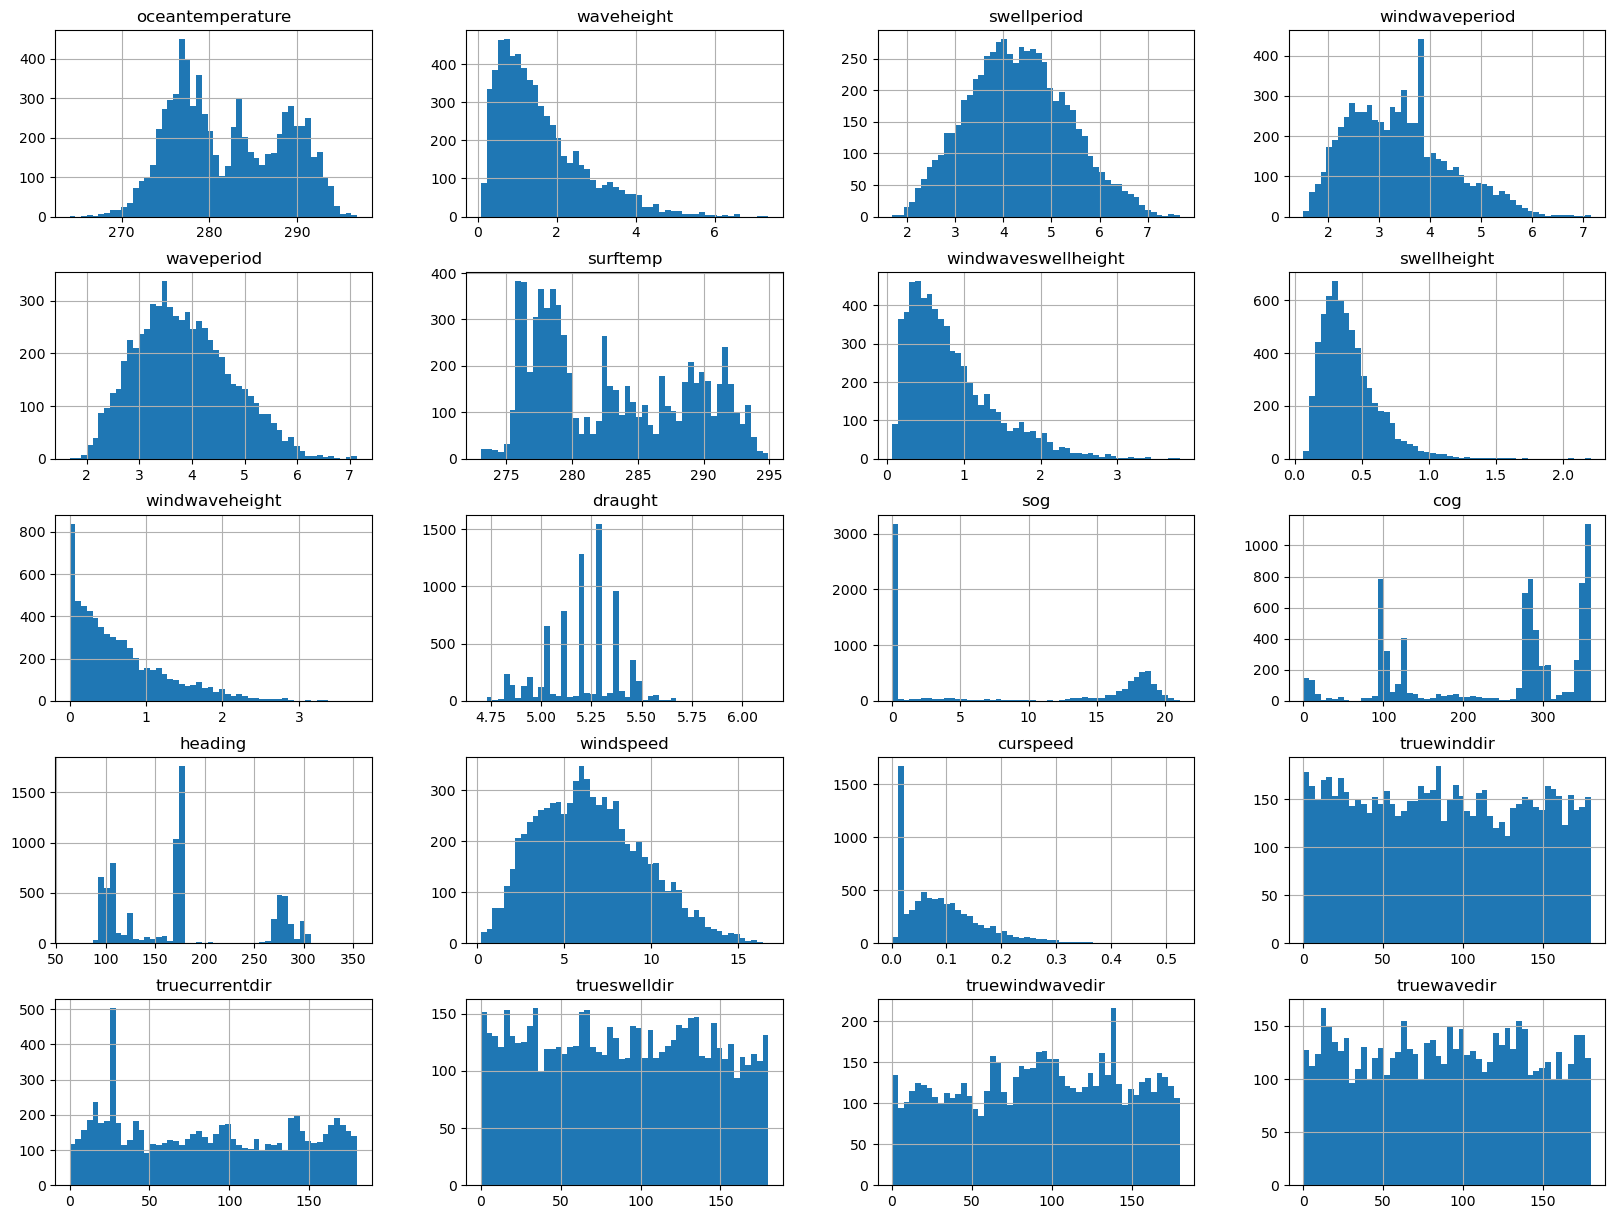

In [ ]:
import matplotlib.pyplot as plt
df_ship2.hist(bins=50,figsize=(20,15))
plt.show()

In [ ]:
corr_matrix = df_ship2.corr()
corr_matrix["sog"]

oceantemperature    0.088598
waveheight         -0.157069
swellperiod        -0.211793
windwaveperiod     -0.109080
waveperiod         -0.210662
                      ...   
truewinddir         0.011425
truecurrentdir      0.083648
trueswelldir        0.012316
truewindwavedir    -0.036343
truewavedir         0.012555
Name: sog, Length: 20, dtype: float64

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer()
imputer.fit(df_ship2)

KNNImputer()

In [ ]:
X = imputer.transform(df_ship2)

In [ ]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [ ]:
df_ship2tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     7453 non-null   float64
 1   waveheight           7453 non-null   float64
 2   swellperiod          7453 non-null   float64
 3   windwaveperiod       7453 non-null   float64
 4   waveperiod           7453 non-null   float64
 5   surftemp             7453 non-null   float64
 6   windwaveswellheight  7453 non-null   float64
 7   swellheight          7453 non-null   float64
 8   windwaveheight       7453 non-null   float64
 9   draught              7453 non-null   float64
 10  sog                  7453 non-null   float64
 11  cog                  7453 non-null   float64
 12  heading              7453 non-null   float64
 13  windspeed            7453 non-null   float64
 14  curspeed             7453 non-null   float64
 15  truewinddir          7453 non-null   f

In [ ]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog'],axis=1),df_ship2tr.sog,test_size=0.2,random_state=42)


In [ ]:
x_train

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir
7849,273.689453,1.903392,5.168277,3.889747,4.129031,278.249023,0.989900,0.419144,0.894226,4.998273,335.799099,173.378172,8.377506,0.077309,52.717592,111.013014,172.903383,128.638033,134.130404
446,276.927002,0.735258,3.607073,1.954018,3.369207,277.552124,0.398392,0.342560,0.162720,5.199557,125.356867,124.934560,4.326051,0.070420,125.368141,121.313346,59.294994,57.766124,63.021755
763,273.599243,1.818458,4.729419,2.375954,4.557055,277.389282,0.956662,0.916744,0.249573,5.110976,359.500000,174.612903,4.602489,0.064624,130.192840,57.165581,19.955646,52.156170,15.603458
2764,278.710449,0.721055,4.557714,2.532387,4.019384,278.912353,0.386143,0.333221,0.168640,5.292658,19.600000,174.000000,4.371434,0.150352,97.937795,99.796772,109.081398,90.140121,102.801010
5033,288.929688,4.489095,5.438617,5.381607,5.382501,291.060547,2.365670,0.290192,2.347656,5.378323,97.229710,94.551523,13.561472,0.016704,0.269007,13.555761,142.799154,176.290762,176.103018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5533,290.820557,0.373232,2.555482,2.812599,2.446046,290.348267,0.212761,0.192871,0.069901,5.380923,99.658091,100.545195,2.429712,0.011765,16.668276,55.550098,114.151476,151.207109,116.679186
5572,288.931152,2.629626,5.389536,4.295948,4.709556,290.358154,1.372685,0.694218,1.141300,5.291434,284.883188,149.342624,5.400804,0.016704,75.284391,68.346862,107.559174,105.198171,103.285263
5761,285.710449,1.085777,5.123824,2.513113,4.283919,288.593994,0.577680,0.455246,0.336029,5.286295,356.400000,174.000000,5.957770,0.158087,59.134771,114.202550,122.145428,123.006043,158.881568
876,272.841065,5.619343,6.726208,6.288489,6.357797,276.691162,2.965053,0.590149,2.880615,5.110293,96.436195,94.400034,15.077783,0.300923,168.875043,159.437190,17.706525,11.097636,10.211573


In [ ]:
y_train

7849     0.217572
446     16.780417
763      0.000000
2764     0.000000
5033    19.618552
          ...    
5533    19.327174
5572     3.143668
5761     0.000000
876     17.887736
7805    17.138849
Name: sog, Length: 5962, dtype: float64

In [ ]:
len(x_train)


5962

In [ ]:
len(x_test)

1491

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train,y_train)

RandomForestRegressor()

In [ ]:
model.score(x_test,y_test)
# r^2 score

0.9882219606614767

In [ ]:
y_predicted = model.predict(x_test)

In [ ]:
# Application for evaluation metrics, starting with explained variance

from sklearn.metrics import explained_variance_score
explained_variance_score(y_test,y_predicted)
# Best value is 1 

0.9882224228782938

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,y_predicted)
# Best value is 0

0.39589873809055

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_predicted)
# Best value is 0

0.874754614720238

In [ ]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test,y_predicted)
# Best value is 0

0.09847252110000682

Parameter optimization using GridSearchCV

In [ ]:
#from sklearn.model_selection import GridSearchCV

#param_grid = [
#    {'n_estimators': [1,100,200], 'min_samples_split': [2,10,20]},
#  ]

#forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
#grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
#                           scoring='neg_mean_squared_error',
#                           return_train_score=True)
#grid_search.fit(x_train, y_train)

In [ ]:
#grid_search.best_params_

In [ ]:
#grid_search.best_estimator_

In [ ]:
#y_pred_grid = grid_search.predict(x_test)

In [ ]:
# Application for evaluation metrics, starting with explained variance

#from sklearn.metrics import explained_variance_score
#explained_variance_score(y_test,y_pred_grid)
# Best value is 1 

In [ ]:
#from sklearn.metrics import mean_absolute_error
#mean_absolute_error(y_test,y_pred_grid)
# Best value is 0

In [ ]:
#from sklearn.metrics import mean_squared_error
#mean_squared_error(y_test,y_pred_grid)
# Best value is 0

In [ ]:
#from sklearn.metrics import median_absolute_error
#median_absolute_error(y_test,y_pred_grid)
# Best value is 0